In [1]:
import time
from pathlib import Path
import textwrap

import numpy as np
import torch
import transformers
from transformers import (AutoConfig, AutoModelForCausalLM, AutoTokenizer,
                          BitsAndBytesConfig)


from modules.GPTQ_loader import load_quantized
from modules.text_generation import generate_reply, plot_char_freq
import modules.shared as shared

shared.model_name = "alpaca-native-4bit"

print(f"Loading {shared.model_name}...")
t0 = time.time()
shared.model = load_quantized(shared.model_name)
shared.tokenizer = AutoTokenizer.from_pretrained(Path(f"models/{shared.model_name}/"))
shared.tokenizer.truncation_side = 'left'


print(f"Loaded the model in {(time.time()-t0):.2f} seconds.")

Loading alpaca-native-4bit...
Loading model ...
Done.
Loaded the model in 12.19 seconds.




Explain why Formula 1 is the fastest racing class in the world.
--------------------

 Output generated in 13.32 seconds (9.39 tokens/s, 125 tokens, context 17) 

  Formula 1 is the pinnacle of motorsport, and it’s easy to see why – the cars reach speeds of up to 220mph on the track, making it the fastest racing
class in the world. The cars are powered by a 2.4-litre V8 engine and weigh around 540kg, meaning they have plenty of power and agility. The cars also
feature advanced aerodynamics which help create downforce at high speeds, allowing them to stick to the track better than any other form of racing.


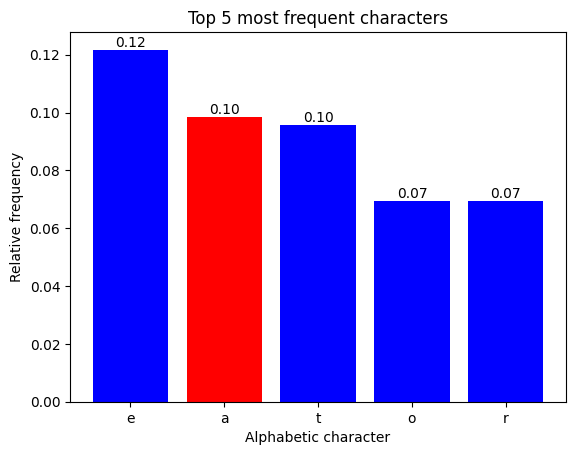

In [2]:
question = "Explain why Formula 1 is the fastest racing class in the world."
shared.delta = 0.0
reply = generate_reply(question, max_new_tokens=200, 
               do_sample=False, 
               temperature=0.95, 
               top_p=1, typical_p=1, 
               repetition_penalty=1.1, 
               encoder_repetition_penalty=1, 
               top_k=40, min_length=0, 
               no_repeat_ngram_size=0, 
               num_beams=1, penalty_alpha=0, 
               length_penalty=1, 
               early_stopping=False, 
               seed=0)

wrapped_string = "\n".join(textwrap.wrap(reply, width=150))
print(wrapped_string)

plot_char_freq(reply, 5)




Explain why Formula 1 is the fastest racing class in the world.
--------------------

 Output generated in 14.71 seconds (11.76 tokens/s, 173 tokens, context 17) 

  Formula 1 is the pinnacle of motorsport, and it’s the fastest racing class in the world. The cars reach speeds up to 220 mph on the track, making it
the most exciting form of racing around. It’s also one of the most technologically advanced classes with cutting-edge technology being used to improve
performance and safety. The cars are powered by a 2.4-liter V8 engine that produces over 750 hp, allowing them to accelerate from 0-60 mph in less
than three seconds. The aerodynamics of the car help reduce drag and optimize downforce for better cornering grip. All these features combine to make
Formula 1 the fastest and most exciting form of racing in the world.


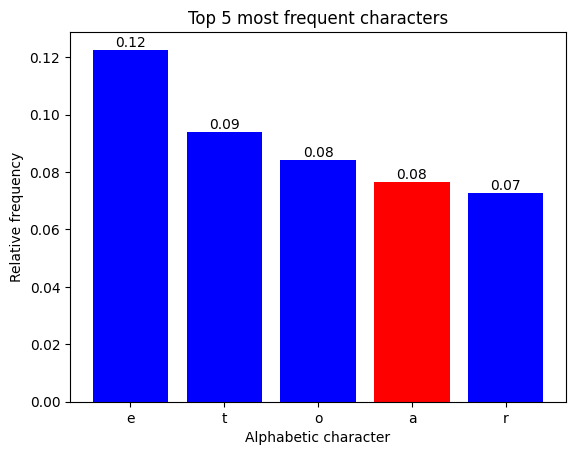

In [4]:
question = "Explain why Formula 1 is the fastest racing class in the world."
shared.delta = -0.5
reply = generate_reply(question, max_new_tokens=200, 
               do_sample=False, 
               temperature=0.95, 
               top_p=1, typical_p=1, 
               repetition_penalty=1.1, 
               encoder_repetition_penalty=1, 
               top_k=40, min_length=0, 
               no_repeat_ngram_size=0, 
               num_beams=1, penalty_alpha=0, 
               length_penalty=1, 
               early_stopping=False, 
               seed=0)

wrapped_string = "\n".join(textwrap.wrap(reply, width=150))
print(wrapped_string)

plot_char_freq(reply, 5)




Explain why Formula 1 is the fastest racing class in the world.
--------------------

 Output generated in 7.84 seconds (10.59 tokens/s, 83 tokens, context 17) 

 Formula 1 cars are purpose-built race machines that are designed to reach speeds of up to 220 mph on the track. They feature advanced aerodynamics,
light weight materials and powerful engines that generate immense amounts of horsepower. This combination of factors allows Formula 1 cars to
accelerate faster than any other type of racing car, making them the fastest in the world.


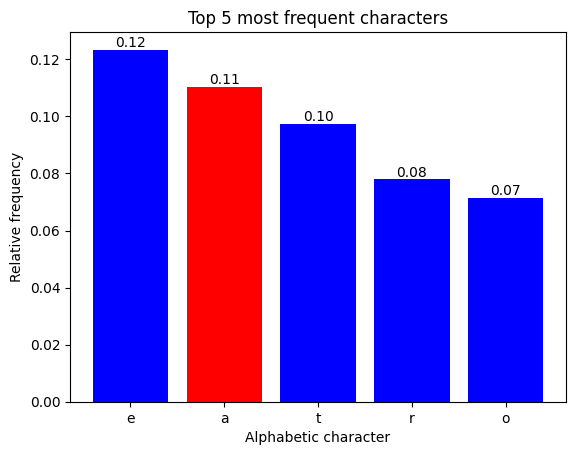

In [5]:
question = "Explain why Formula 1 is the fastest racing class in the world."
shared.delta = 0.5
reply = generate_reply(question, max_new_tokens=200, 
               do_sample=False, 
               temperature=0.95, 
               top_p=1, typical_p=1, 
               repetition_penalty=1.1, 
               encoder_repetition_penalty=1, 
               top_k=40, min_length=0, 
               no_repeat_ngram_size=0, 
               num_beams=1, penalty_alpha=0, 
               length_penalty=1, 
               early_stopping=False, 
               seed=0)

wrapped_string = "\n".join(textwrap.wrap(reply, width=150))
print(wrapped_string)

plot_char_freq(reply, 5)



Explain why Formula 1 is the fastest racing class in the world.
--------------------

 Output generated in 17.10 seconds (11.69 tokens/s, 200 tokens, context 17) 

 Formula 1 cars are among the fastest accelerating machines ever made by man and have a maximum speed limit of around 220 km/h (136 mph). Formula 1
cars are also among the smallest and lightest race cars around, making them ideal for racing and maneuvering at high spears. Formula 1 cars are also
among the most advanced racing cars thanks to a combination of aerodynamics and advanced automated features that allow racers to adjust various
parameters according to track and weather conditions as well as their own personal preferences. Formula 1 cars also feature advanced safety measures
and are among the safest racing cars available today thanks to a combination of advanced safety features and a variety of safety measures taken during
races and practice sessions. Finally Formula 1 cars are also among the least affordable racin

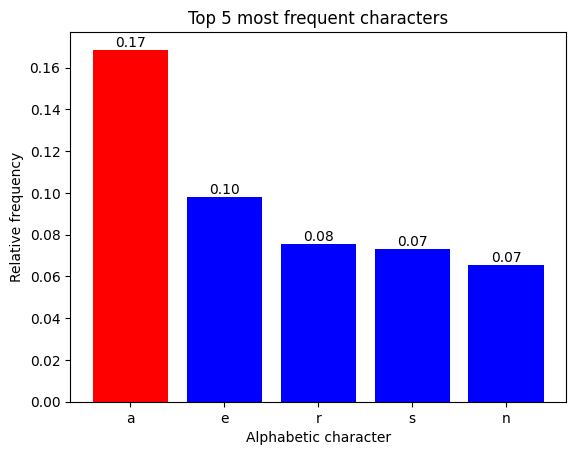

In [6]:
question = "Explain why Formula 1 is the fastest racing class in the world."
shared.delta = 5.0
reply = generate_reply(question, max_new_tokens=200, 
               do_sample=False, 
               temperature=0.95, 
               top_p=1, typical_p=1, 
               repetition_penalty=1.1, 
               encoder_repetition_penalty=1, 
               top_k=40, min_length=0, 
               no_repeat_ngram_size=0, 
               num_beams=1, penalty_alpha=0, 
               length_penalty=1, 
               early_stopping=False, 
               seed=0)

wrapped_string = "\n".join(textwrap.wrap(reply, width=150))
print(wrapped_string)

plot_char_freq(reply, 5)